In [1]:
import pandas as pd
from pgmpy.factors.discrete import TabularCPD
import numpy as np

# Bayesan network

Let's load the dataset first in order to create a bayesan network.

In [2]:
data = pd.read_csv("data.csv") \
    .rename(columns={"Unnamed: 0": "ISO3"}) \
    .set_index("iso3")

In [3]:
data.head()

name    Time  enrolment_primary_female  \
iso3                                                          
AFG           Afghanistan  2018.0                 2549573.0   
ALB               Albania  2019.0                   79342.0   
AIA              Anguilla  2019.0                     745.0   
ATG   Antigua and Barbuda  2018.0                    4981.0   
ARG             Argentina  2018.0                 2345904.0   

      enrolment_lower-secondary_female  enrolment_upper-secondary_female  \
iso3                                                                       
AFG                           708606.0                          367543.0   
ALB                            65721.0                           54469.0   
AIA                              306.0                             187.0   
ATG                             2236.0                            1576.0   
ARG                          1349677.0                          949778.0   

      enrolment_upper-secondary_male  enrolment_primary_male  \
iso3                                                           
AFG                         713477.0               3995333.0   
ALB                          62177.0                 87762.0   
AIA                            199.0                   767.0   
ATG                           1425.0                  5142.0   
ARG                         880337.0               2430548.0   

      enrolment_lower-secondary_male  primary_female  primary_male  ...  \
iso3                                                                ...   
AFG                        1274263.0       2549573.0     3995333.0  ...   
ALB                          73705.0         79342.0       87762.0  ...   
AIA                            320.0           745.0         767.0  ...   
ATG                           2619.0          4981.0        5142.0  ...   
ARG                        1402392.0       2345904.0     2430548.0  ...   

      upper-secondary_female  upper-secondary_male  \
iso3                                                 
AFG                1289337.0             1360804.0   
ALB                  59256.0               66593.0   
AIA                    197.0                 200.0   
ATG                   1576.0                1425.0   
ARG                1041265.0             1077217.0   

                               region  academic_break closed  open  \
iso3                                                                 
AFG                        South Asia            32.0  115.0  55.0   
ALB   Eastern Europe and Central Asia            77.0   41.0  92.0   
AIA       Latin America and Caribbean            62.0   20.0  93.0   
ATG       Latin America and Caribbean            64.0   78.0   2.0   
ARG       Latin America and Caribbean            33.0  111.0   3.0   

      partially_closed     tv  radio  internet  
iso3                                            
AFG               33.0   True   True      True  
ALB               25.0   True   True      True  
AIA               60.0  False  False     False  
ATG               91.0   True  False     False  
ARG               88.0   True   True      True  

[5 rows x 22 columns]

We are going to use the following network structure.

Red characters represents abbreviations that will be used in the code.

<img src="education_network.jpg" alt="Bayesan Network Sketch" width="600"/>

In [4]:
state_names = {
    "Country": list(data.index),
    "Gender": ["male", "female"],
    "Region": list(data["region"].sort_values().unique()),
    "Education": ["primary", "lower-secondary", "upper-secondary"],
    "AtHome": ["yes", "no"],
    "RadioReach": ["yes", "no"],
    "InternetReach": ["yes", "no"],
    "TvReach": ["yes", "no"],
    "RadioMeasure": ["yes", "no"],
    "InternetMeasure": ["yes", "no"],
    "TvMeasure": ["yes", "no"]
}

### Create CPDs

#### $P(R)$

Probability of being in a region, $P(Region)$, can be computed as

$$P(R = x) = \frac{Child_x}{\sum\limits_{r \in regions} Population_r}$$

with $x$ being a particular region.

In [6]:
male_columns = ["primary_male", "lower-secondary_male", "upper-secondary_male"]
female_columns = ["primary_female", "lower-secondary_female", "upper-secondary_female"]
school_pop_cols = male_columns + female_columns

region_population = data.groupby(["region"]).sum()[school_pop_cols].sum(axis=1)
p_in_region = region_population / region_population.sum()

In [7]:
cpd_Region = TabularCPD(variable="Region", 
                   variable_card=p_in_region.count(), 
                   values=np.array([[x] for x in p_in_region.to_numpy()]),
                   state_names=state_names)

#### $P(C | R)$
Then we build the CPD of a child being in a country, $P(Country | Region)$, which depends on the region he is from.

Given $x$ an arbitrary country and $r$ a region
$$P(C = x | R = r) = \frac{population_x}{population_r}$$

In [8]:
school_age_per_country = data[school_pop_cols].sum(axis=1)
p_in_country = school_age_per_country / school_age_per_country.sum()

regions = data["region"].sort_values().unique()
p_in_country = pd.DataFrame(data=np.zeros((len(data.index), len(regions))),
                            index=data.index,
                            columns=regions)
for region in regions:
    countries_in_region = data["region"] == region
    p_in_country.loc[countries_in_region, region] = school_age_per_country[countries_in_region]
    p_in_country[region] = p_in_country[region].div(region_population[region])

In [9]:
cpd_Country = TabularCPD(variable="Country", 
                         variable_card=len(data.index),
                         values=p_in_country.to_numpy(),
                         evidence=["Region"],
                         evidence_card=[len(regions)],
                         state_names=state_names)

#### $P(G | C)$

Computing the probability of being a male or a female, $P(Gender)$, depends on the country the child is living in.
We can compute the probability of being male in a country $x$ as
$$
\begin{align*}
P(G = male | C = x) &= \frac{P(G = male, C = x)}{P(C = x)} \\
&= \frac{Males_x}{\sum\limits_{c \in countries} population_c}
\end{align*}
$$
and probability of being female as $1 - P(G = male | C = x)$.

In [10]:
p_male = data[male_columns].sum(axis=1) / school_age_per_country
p_female = 1 - p_male

In [11]:
cpd_Gender = TabularCPD(variable="Gender", 
                   variable_card=2, # male, female
                   values=np.array([p_male, p_female]),
                   evidence=["Country"],
                   evidence_card=[p_male.count()],
                   state_names=state_names)

#### $P(E | G, C)$

Probability $P(E)$ of being in a particular education depends on gender and country.

The probability of a male child in primary school in a country $x$ is

$$
\begin{align*}
P(E = primary\text{-}school | G = male, C = x) &= \frac{P(E = primary\text{-}school, G = male, C = x)}{P(G = male, C = x)} \\
&= \frac{MaleInPrimarySchool_x}{\sum\limits_{c \in countries} MaleInPrimarySchool_c} \frac{1}{P(G = male, C = x)}
\end{align*}
$$

Conditional probability table is defined as

| male |  |  |  | female |  |  |  |
|---|---|---|---|---|---|---|---|
| primary | lower-secondary | upper-secondary | out-of-school | primary | lower-secondary | upper-secondary | out-of-school |
| $C_1 \cdots C_n$ | $C_1 \cdots C_n$ | $C_1 \cdots C_n$ | $C_1 \cdots C_n$ | $C_1 \cdots C_n$ | $C_1 \cdots C_n$ | $C_1 \cdots C_n$ | $C_1 \cdots C_n$ |

In [12]:
education_columns = ["primary", "lower-secondary", "upper-secondary"]
enrolment_columns = ["enrolment_" + c for c in education_columns]

male_education_columns = [c + "_male" for c in education_columns]
male_enrolment_columns = [c + "_male" for c in enrolment_columns]
female_education_columns = [c + "_female" for c in education_columns]
female_enrolment_columns = [c + "_female" for c in enrolment_columns]

If we perform the computation we end up with some weird results: some countries have a probability of child being in school higher than $1$.
This is because of rounding approximations in the values computation so we simply change those probabilities to sum up to 1.

In [13]:
education_male = data[male_enrolment_columns].div(data[male_enrolment_columns].sum(axis=1), axis="index")
approx_err_idx = education_male.sum(axis=1) > 1
education_male[approx_err_idx] = education_male[approx_err_idx].div(education_male[approx_err_idx].sum(axis=1), axis="index")

education_female = data[female_enrolment_columns].div(data[female_enrolment_columns].sum(axis=1), axis="index")
approx_err_idx = education_female.sum(axis=1) > 1
education_female[approx_err_idx] = education_female[approx_err_idx].div(education_female[approx_err_idx].sum(axis=1), axis="index")

In [14]:
cpd_Education = TabularCPD(variable="Education", 
                   variable_card=3, # primary, lower secondary, upper secondary
                   # append education_female columns to education_male ones
                   values=np.c_[education_male.transpose().to_numpy(), education_female.transpose().to_numpy()],
                   evidence=["Gender", "Country"],
                   evidence_card=[
                       2, # gender
                       len(data.index) # countries
                   ],
                   state_names=state_names)

#### $P(AtHome | C)$

Probability of staying at home $P(AtHome)$ because school was closed depends only the country.
The probability of living in country x and of being at home is

$$P(AtHome = yes | C = x) = \frac{P(AtHome = yes, C = x)}{P(C = x)} = \frac{DaysAtHome_x}{SchoolDays_x}$$

In [15]:
at_home_cols = ["closed", "partially_closed"]
tot_school_days = ["closed", "open", "partially_closed"]
p_at_home = data[at_home_cols].sum(axis=1).div(data[tot_school_days].sum(axis=1))
p_at_school = 1 - p_at_home

In [16]:
cpd_AtHome = TabularCPD(variable="AtHome", 
                        variable_card=2, 
                        values=np.array([p_at_home, p_at_school]),
                        evidence=["Country"],
                        evidence_card=[len(data.index)],
                        state_names=state_names)

#### Media reachability

Probability of being reached by a media platform can't be modeled as a unique CPD as values intersects and we cannot disaggregate them.
Because of this we compute 3 different probability distributions: $P(Internet)$, $P(Radio)$, $P(Tv)$.

Each of them, for instance $P(Internet)$, can be computed as

$$
\begin{align*}
P(I = yes | E = primary, R = x) &= \frac{P(MR = internet, E = primary, R = x)}{P(E = primary, R = x)} \\
& = \frac{PrimaryReachedByInternet_x}{\sum\limits_{r \in regions} PrimaryReachedByInternet_r}
\end{align*}
$$

with $x$ being a certain region.

In [17]:
media = pd.read_csv("media.csv") \
    .rename(columns={"Unnamed: 0": "region"}) \
    .set_index("region")

Unfortunately we don't have enough data all over the world.

In [18]:
missing_regions = list()
for r in data["region"].unique():
    if r not in media.index.unique():
        print(r, "is absent")
        missing_regions.append(r)

Western Europe is absent
North America is absent


If we check which regions are missing, though, we can see that realistically they're regions rich enough in which we can safely assume that radio, internet and television accessibility is widespread in each country and therefore each student can receive education from these media types.

In [19]:
education_columns = [["enrolment_primary_male", "enrolment_primary_female"], 
                     ["enrolment_lower-secondary_male", "enrolment_lower-secondary_female"], 
                     ["enrolment_upper-secondary_male", "enrolment_lower-secondary_female"]]

data_region = data.groupby("region").sum()
data_region = pd.DataFrame(
    data=data_region[male_enrolment_columns].to_numpy() + data_region[female_enrolment_columns].to_numpy(),
    index=data_region.index
)

In [31]:
# internet
media_columns = [c for c in media.columns if "internet" in c]
p_internet = (media[media_columns] / data_region.rename(columns={i: c for i, c in enumerate(media_columns)})).transpose()
p_internet[p_internet.isna()] = 1
p_internet = p_internet.to_numpy().flatten()

cpd_InternetReach = TabularCPD(variable="InternetReach", 
                   variable_card=2, # yes, no
                   values=np.array([p_internet, 1 - p_internet]),
                   evidence=["Education", "Region"],
                   evidence_card=[3, len(data_region.index)],
                   state_names=state_names)

In [32]:
# radio
media_columns = [c for c in media.columns if "radio" in c]
p_radio = (media[media_columns] / data_region.rename(columns={i: c for i, c in enumerate(media_columns)})).transpose()
p_radio[p_radio.isna()] = 1
p_radio = p_radio.to_numpy().flatten()

cpd_RadioReach = TabularCPD(variable="RadioReach", 
                    variable_card=2, # yes, no
                    values=np.array([p_radio, 1 - p_radio]),
                    evidence=["Education", "Region"],
                    evidence_card=[3, len(data_region.index)],
                    state_names=state_names)

In [33]:
# tv
media_columns = [c for c in media.columns if "tv" in c]
p_tv = (media[media_columns] / data_region.rename(columns={i: c for i, c in enumerate(media_columns)})).transpose()
p_tv[p_tv.isna()] = 1
p_tv = p_tv.to_numpy().flatten()

cpd_TvReach = TabularCPD(variable="TvReach", 
                    variable_card=2, # yes, no
                    values=np.array([p_tv, 1 - p_tv]),
                    evidence=["Education", "Region"],
                    evidence_card=[3, len(data_region.index)],
                    state_names=state_names)

#### Measures implemented
Last we build the probability distribution of a certain measure being taken in different countries.
Measures includes distant learning by Radio, Television and Internet so we will compute 3 different probability distributions.

In [34]:
p_internet = data["internet"].astype(float)
cpd_InternetMeasure = TabularCPD(variable="InternetMeasure", 
                                 variable_card=2, # yes, no
                                 values=np.array([p_internet, 1 - p_internet]),
                                 evidence=["Country"],
                                 evidence_card=[len(data.index)],
                                 state_names=state_names)

In [35]:
p_radio = data["radio"].astype(float)
cpd_RadioMeasure = TabularCPD(variable="RadioMeasure", 
                              variable_card=2, # yes, no
                              values=np.array([p_radio, 1 - p_radio]),
                              evidence=["Country"],
                              evidence_card=[len(data.index)],
                              state_names=state_names)

In [36]:
p_tv = data["tv"].astype(float)
cpd_TvMeasure = TabularCPD(variable="TvMeasure", 
                           variable_card=2, # yes, no
                           values=np.array([p_internet, 1 - p_internet]),
                           evidence=["Country"],
                           evidence_card=[len(data.index)],
                           state_names=state_names)

### Model

In [37]:
from pgmpy.models import BayesianModel

model = BayesianModel([("Region", "Country"),
                       ("Country", "Gender"), ("Country", "AtHome"),
                       ("Country", "TvMeasure"), ("Country", "InternetMeasure"), ("Country", "RadioMeasure"),
                       ("Country", "Education"), ("Gender", "Education"),
                       ("Region", "InternetReach"), ("Region", "RadioReach"), ("Region", "TvReach"),
                       ("Education", "InternetReach"), ("Education", "RadioReach"), ("Education", "TvReach")
                      ])

In [38]:
model.add_cpds(cpd_Region, cpd_Country, 
               cpd_Gender, cpd_AtHome,
               cpd_TvMeasure, cpd_InternetMeasure, cpd_RadioMeasure,
               cpd_Education,
               cpd_InternetReach, cpd_RadioReach, cpd_TvReach)

In [39]:
model.check_model()

True

### Inference

We can now perform the inference steps and see if we can discover some interesting insights from the data.
We will do that by using the `VariableElimination` inference method.

In [40]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

We can see, for example, the world-wide probability of being at home in the registered period. 

In [41]:
print(infer.query(["AtHome"], show_progress=False))

+-------------+---------------+
| AtHome      |   phi(AtHome) |
+=============+===============+
| AtHome(yes) |        0.8031 |
+-------------+---------------+
| AtHome(no)  |        0.1969 |
+-------------+---------------+


We can see it by regions by plotting it using a stacked bar chart.

In [42]:
p = dict()
for region in regions:
    p[region] = infer.query(["AtHome"], evidence={"Region": region}, show_progress=False)

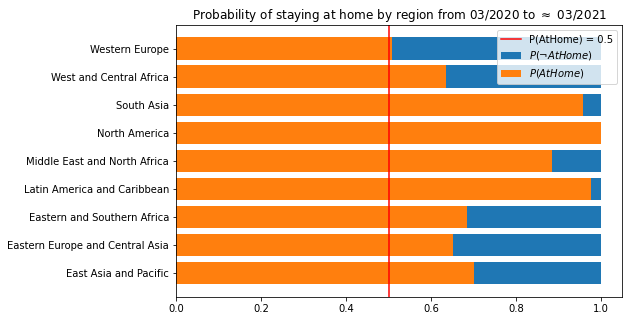

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.barh(regions, [1 for x in p.values()], label="$P(\\neg AtHome)$")
plt.barh(regions, [x.values[0] for x in p.values()], label="$P(AtHome)$")
plt.axvline(x=.5, ymin=0, ymax=1, color="red", label="P(AtHome) = 0.5")
plt.title("Probability of staying at home by region from 03/2020 to $\\approx$ 03/2021")
plt.legend()
plt.show()

We could also compute it by country, but the visualization would be higlhy cluttered, so it's better to use a more powerful tool.

We can check what is the probability of implementing distant learning using internet

In [44]:
print(infer.query(["InternetMeasure"], show_progress=False))

+----------------------+------------------------+
| InternetMeasure      |   phi(InternetMeasure) |
+======================+========================+
| InternetMeasure(yes) |                 0.9388 |
+----------------------+------------------------+
| InternetMeasure(no)  |                 0.0612 |
+----------------------+------------------------+


we can also check what is the probability of being reached by an internet connection

In [45]:
print(infer.query(["InternetReach"], show_progress=False))

+--------------------+----------------------+
| InternetReach      |   phi(InternetReach) |
+====================+======================+
| InternetReach(yes) |               0.3288 |
+--------------------+----------------------+
| InternetReach(no)  |               0.6712 |
+--------------------+----------------------+


and we can combine the two to see what is the probability of being unable to use distant learning through internet, even though the country is actually providing it

In [47]:
print(infer.query(["InternetMeasure", "InternetReach"], show_progress=False))

+----------------------+--------------------+--------------------------------------+
| InternetMeasure      | InternetReach      |   phi(InternetMeasure,InternetReach) |
+======================+====================+======================================+
| InternetMeasure(yes) | InternetReach(yes) |                               0.3182 |
+----------------------+--------------------+--------------------------------------+
| InternetMeasure(yes) | InternetReach(no)  |                               0.6206 |
+----------------------+--------------------+--------------------------------------+
| InternetMeasure(no)  | InternetReach(yes) |                               0.0106 |
+----------------------+--------------------+--------------------------------------+
| InternetMeasure(no)  | InternetReach(no)  |                               0.0506 |
+----------------------+--------------------+--------------------------------------+


in fact it is $0.62$, quite high!

We can of course see if that is the case for all the measures.
The output would be quite confusing however to inspect, so for instance let's check what is the probability of not being able to use 
any distant learning measure.

In [48]:
x = infer.query(["InternetReach"], show_progress=False).values[1]
x *= infer.query(["RadioReach"], show_progress=False).values[1]
x *= infer.query(["TvReach"], show_progress=False).values[1]
print("p(phi) = %f" % x)

p(phi) = 0.133222


We can see how this probability changes in different regions

In [49]:
p = dict()
for region in regions:
    p[region] = infer.query(["InternetReach"], evidence={"Region": region}, show_progress=False).values[1]
    p[region] *= infer.query(["RadioReach"], evidence={"Region": region}, show_progress=False).values[1]
    p[region] *= infer.query(["TvReach"], evidence={"Region": region}, show_progress=False).values[1]

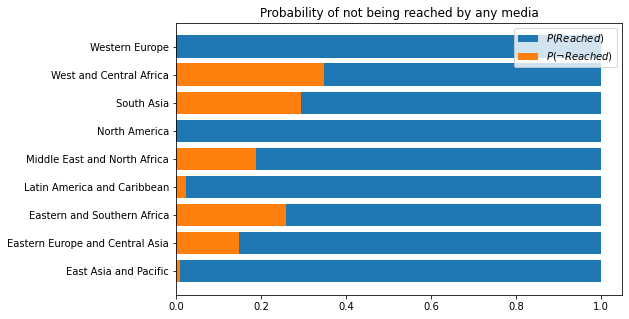

In [50]:
plt.figure(figsize=(8, 5))
plt.barh(regions, [1 for x in p.values()], label="$P(Reached)$")
plt.barh(regions, [x for x in p.values()], label="$P(\\neg Reached)$")
plt.title("Probability of not being reached by any media")
plt.legend()
plt.show()

The probability of not being reached by any media is quite high in non-developed regions

We can also express some more complex queries, for example the gender probability distribution in countries which are only reached by radio media, which is an adopted distant learning measure.

In [51]:
print(infer.query(["Gender"], 
                  evidence={"RadioReach": "yes", "TvReach": "no", "InternetReach": "no", "RadioMeasure": "yes"}, 
                  show_progress=False))

+----------------+---------------+
| Gender         |   phi(Gender) |
+================+===============+
| Gender(male)   |        0.5077 |
+----------------+---------------+
| Gender(female) |        0.4923 |
+----------------+---------------+


Or we could see the probability of being at a certain education level, staying at home and not being able to be reached by any distant learning measure at all. 

In [52]:
print(infer.query(["Education"], 
                  evidence={"RadioReach": "no", "TvReach": "no", "InternetReach": "no", "AtHome": "yes"}, 
                  show_progress=False))

+----------------------------+------------------+
| Education                  |   phi(Education) |
+============================+==================+
| Education(primary)         |           0.6157 |
+----------------------------+------------------+
| Education(lower-secondary) |           0.2362 |
+----------------------------+------------------+
| Education(upper-secondary) |           0.1481 |
+----------------------------+------------------+


We can also make use of the bayesian network to perform some predictions, for instance, which is the media that is most probable to reach children?

In [53]:
print(infer.map_query(["RadioReach", "InternetReach", "TvReach"], show_progress=False))

{'RadioReach': 'no', 'InternetReach': 'no', 'TvReach': 'yes'}


As we can see using television as a distant learning tool is the best way to reach everyone.

We can check if it is different for different regions

In [60]:
df = pd.DataFrame(index=regions,
                  columns=["radio", "internet", "tv"],
                  data=np.zeros((len(regions), 3)))

for region in regions:
    x = infer.map_query(["RadioReach", "InternetReach", "TvReach"], evidence={"Region": region}, show_progress=False)
    df.loc[region, "internet"] = x["InternetReach"]
    df.loc[region, "radio"] = x["RadioReach"]
    df.loc[region, "tv"] = x["TvReach"]

df = df.style.applymap(lambda x: "color: red" if str(x) == "no" else "color: green")
df

We can also predict which measures has been taken for different education levels

In [67]:
for education in ["primary", "lower-secondary", "upper-secondary"]:
    x = infer.map_query(["InternetMeasure", "RadioMeasure", "TvMeasure"], evidence={"Education": education}, show_progress=False)
    print(education, x)

primary {'InternetMeasure': 'yes', 'RadioMeasure': 'no', 'TvMeasure': 'yes'}
lower-secondary {'InternetMeasure': 'yes', 'RadioMeasure': 'no', 'TvMeasure': 'yes'}
upper-secondary {'InternetMeasure': 'yes', 'RadioMeasure': 'no', 'TvMeasure': 'yes'}
